## Lending Club Case Study - Exploratory Data Analysis

### Group Members:
 Nikhil Oommen Jacob <br>
 Ragula Srinivas

### Project Brief

Solving this assignment will give you an idea about how real business problems are solved using EDA. In this case study, apart from applying the techniques you have learnt in EDA, you will also develop a basic understanding of risk analytics in banking and financial services and understand how data is used to minimise the risk of losing money while lending to customers.


### Business Understanding

You work for a consumer finance company which specialises in lending various types of loans to urban customers. When the company receives a loan application, the company has to make a decision for loan approval based on the applicant’s profile. Two types of risks are associated with the bank’s decision:
<ul>
<li>If the applicant is likely to repay the loan, then not approving the loan results in a loss of business to the company
</li>
<li>If the applicant is not likely to repay the loan, i.e. he/she is likely to default, then approving the loan may lead to a financial loss for the company</li>
</ul>
The data given below contains the information about past loan applicants and whether they ‘defaulted’ or not. The aim is to identify patterns which indicate if a person is likely to default, which may be used for taking actions such as denying the loan, reducing the amount of loan, lending (to risky applicants) at a higher interest rate, etc.

In this case study, you will use EDA to understand how <b>consumer attributes</b> and <b>loan attributes</b> influence the tendency of default.




### Business Objectives

This company is the largest online loan marketplace, facilitating personal loans, business loans, and financing of medical procedures. Borrowers can easily access lower interest rate loans through a fast online interface.

Like most other lending companies, lending loans to ‘risky’ applicants is the largest source of financial loss (called credit loss). The credit loss is the amount of money lost by the lender when the borrower refuses to pay or runs away with the money owed. In other words, borrowers who default cause the largest amount of loss to the lenders. In this case, the customers labelled as 'charged-off' are the 'defaulters'.

If one is able to identify these risky loan applicants, then such loans can be reduced thereby cutting down the amount of credit loss. Identification of such applicants using EDA is the aim of this case study.

In other words, the company wants to understand the driving factors (or driver variables) behind loan default, i.e. the variables which are strong indicators of default. The company can utilise this knowledge for its portfolio and risk assessment.

### Importing packages

In [17]:
#Load the necessary Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
sns.set(style='whitegrid')
import datetime as dt

import warnings
warnings.filterwarnings('ignore')

### Load Data

In [6]:
#Load the dataset
loan = pd.read_csv('loan.csv',encoding = "ISO-8859-1", low_memory=False, index_col='id',
    dtype={
        'id':object, 
        'member_id': object
    })

loan.shape

(39717, 110)

**Q1)** Load the dataset and plot a histogram for the `Score A` column by keeping the `number of bins to 6`. Which bin range among the following has the highest frequency?

(`Note` - *The bin ranges mentioned in the options are approximate values for the bin ranges that you'll actually get when you plot the histogram*)

    a)0-50
    b)50-100
    c)150-200
    d)200-250

## Clean Data
### Drop empty columns

In [7]:
# Drop empty columns
loan.dropna(how='all',axis=1,inplace=True)

### Drop irrelevant variables
Some of the variables are irrelevant to the ability to payback the load. So we can remove this data

In [8]:
# Drop irrelevant variables
loan.drop(
    labels=[
        'member_id',
        'zip_code',
        'url',
        'title',
        'desc',
        'tax_liens',
        'emp_title',
        'chargeoff_within_12_mths',
        'collections_12_mths_ex_med',
    ],
    axis=1,
    inplace=True
)

## Drop columns that have too many missing values (lets say 10%) 

In [10]:
# Drop columns that have significant in number of missing values
for col in loan.columns:
    missing_data = loan[col].isna().sum()
    if missing_data / loan.shape[0] >= 0.1:
        loan.drop(col, axis=1, inplace=True)
     

## Drop rows that have too many missing values (lets say 10%) 

In [12]:
# Drop rows that have significant in number of missing values
for row in loan.index:
    missing_data = loan.loc[row].isna().sum()
    if missing_data / loan.shape[1] >= 0.1:
        loan.drop(row, axis=1, inplace=True)

## Convert percentage variables to decimal numbers
Data read from .csv files could be parsed as strings rather than implying data type. For example, 10.30% could be parsed as "10.30%", which is a string, rather than a float. This doesnt allow us to do any analysis on it. Therefore we have to convert this to floating number

In [15]:
# function to convert percentage strings to float
def convert_pct(x):
    if x == x: # If x is not NaN, it must be equal to itself
        result = float(x.rstrip('%'))
    else:
        result = x
    return result
#this function must be applied to 2 columns
column_list = ['int_rate', 'revol_util']
for col in column_list:
    loan[col] = loan[col].map(convert_pct)



## Convert date strings to dates
We have to convert the dates which are in string format to date format to do any analysis


In [18]:
# function to convert date strings to date
def convert_date(x):
    if x == x: # If x is not NaN, it must be equal to itself
        result = dt.datetime.strptime(x,'%b-%y').date()
    else:
        result = x
    return result
#above function should be applied to 4 columns
column_list = ['issue_d', 'earliest_cr_line', 'last_pymnt_d', 'last_credit_pull_d']
for col in column_list:
    loan[col] = loan[col].map(convert_date)

## Exploratory Data Analysis

Definition : In our analysis, Default Ratio (%) on each segment is calculated as the ratio of borrowers in a particular segment who actually defaulted on the total number of borrowers in that segment

### Analysis on Grade and Default Risk

Our very first analysis is to look at the grade assigned to each loan's application. Loan's grade reflects how risky a loan is and how likely it could be defaulted. Here, we would like to see if loans of better grades was actually safer than those of worse grades.

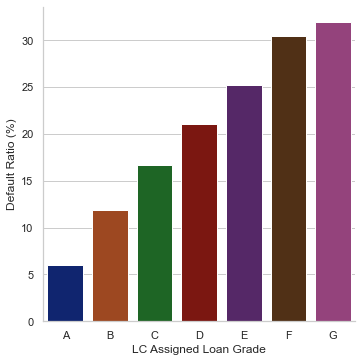

In [23]:
# Calculate Default Ratio by Grade group
defaulters_by_grade = loan.groupby(['grade','loan_status'])['loan_status'].count().unstack(level=1)
defaulters_by_grade.fillna(0,inplace=True)
borrowers_by_grade = defaulters_by_grade.sum(axis=1)
defaulters_by_grade['default_ratio'] = defaulters_by_grade['Charged Off'] / borrowers_by_grade * 100
defaulters_by_grade = defaulters_by_grade[['default_ratio']]
defaulters_by_grade.reset_index(inplace=True)

# Graph
g = sns.catplot(data=defaulters_by_grade,kind='bar',x='grade',y='default_ratio',palette='dark')
g.set_axis_labels('LC Assigned Loan Grade','Default Ratio (%)')

As can be seen, default ratio consistently increases from best grades to worst grades. It confirms that <B>we incur the ration of defautlters increases with with loans of bad grades </b>. Next, we will go further by breaking down grades into subgrades

## Analysis on Sub-grade & Default Risk
Here, we will take a further step to see what happens between subgrades

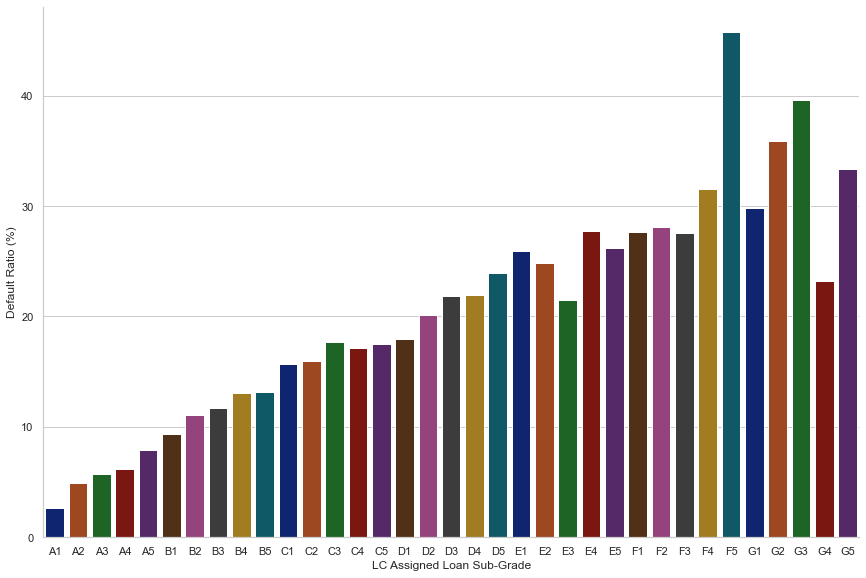

In [27]:
# Calculate Default Ratio by Sub-grade group
defaulters_ratio_by_subgrade = loan.groupby(['sub_grade','loan_status'])['loan_status'].count().unstack(level=1)
defaulters_ratio_by_subgrade.fillna(0,inplace=True)
borrowers_by_subgrade = defaulters_ratio_by_subgrade.sum(axis=1)
defaulters_ratio_by_subgrade['default_ratio'] = defaulters_ratio_by_subgrade['Charged Off'] / borrowers_by_subgrade * 100
defaulters_ratio_by_subgrade = defaulters_ratio_by_subgrade[['default_ratio']]
defaulters_ratio_by_subgrade.reset_index(inplace=True)

# Graph
g = sns.catplot(
    data=defaulters_ratio_by_subgrade,
    kind='bar',
    x='sub_grade',
    y='default_ratio',
    palette='dark',
    height=8, 
    aspect=12/8,
    
)
g.set_axis_labels('LC Assigned Loan Sub-Grade','Default Ratio (%)')

As seen in the above graph, the relationship between assigned subgrades and default ratio remains consistent from subgrades A1 to F5. The only exception is seen among subgrades in grade G. There is no clear evidence of the trend, this could be explained considering there are only few borrowers classified into these subgrades; hence, the default ratio could vary due to small sample size.

## Analysis on Loan Term & Default Risk
This analysis answers the question whether longer-term an shorter-term loans are invariant with respect to default ratio

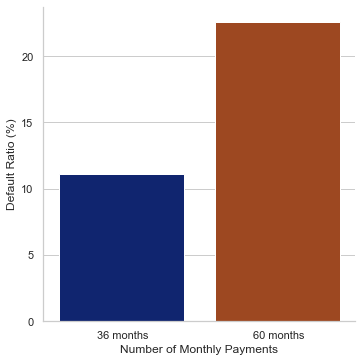

In [29]:
# Calculate Default Ratio by Term
defaulters_ratio_by_term = loan.groupby(['term','loan_status'])['loan_status'].count().unstack(level=1)
defaulters_ratio_by_term.fillna(0,inplace=True)
borrowers_by_term = defaulters_ratio_by_term.sum(axis=1)
defaulters_ratio_by_term['default_ratio'] = defaulters_ratio_by_term['Charged Off'] / borrowers_by_term * 100
defaulters_ratio_by_term = defaulters_ratio_by_term[['default_ratio']]
defaulters_ratio_by_term.reset_index(inplace=True)

# Graph
g = sns.catplot(data=defaulters_ratio_by_term,kind='bar',x='term',y='default_ratio',palette='dark')
g.set_axis_labels('Number of Monthly Payments','Default Ratio (%)')

Loans with 36 monthly payments are much less risker than loans with 60 monthly payments. To summarise, shorter term implies less risk of defaulters and vice versa

## Analysis on Income Level & Default Risk

In this analysis, we divide the borrowers into 4 groups corresponding to their income level:

Below 25th percentile: income_level = 'low'
From 25th percentile to 50th percentile: income_level = 'lower_medium'
From 50th percentile to 75th percentile: income_level = 'upper_medium'
Above 75th percentile: income_level = 'high'
    
We first do the classification:

In [31]:
# Classify customers by income levels
def classify_income(income_series):
    first_quartile = income_series.quantile(0.25)
    second_quartile = income_series.quantile(0.5)
    third_quartile = income_series.quantile(0.75)
    result = income_series.copy()
    result.loc[income_series < first_quartile] = 'low'
    result.loc[(first_quartile <= income_series) & (income_series < second_quartile)] = 'lower_medium'
    result.loc[(second_quartile <= income_series) & (income_series < third_quartile)] = 'upper_medium'
    result.loc[third_quartile <= income_series] = 'high'
    return result
loan['income_level'] = loan['annual_inc'].transform(classify_income)

In [33]:
# Calculate Default Ratio by Employment
defaulters_ratio_by_employment = loan.groupby(['income_level','emp_length','loan_status'])['loan_status'].count().unstack(level=2)
defaulters_ratio_by_employment.fillna(0,inplace=True)
borrowers_by_employment = defaulters_ratio_by_employment.sum(axis=1)
defaulters_ratio_by_employment['default_ratio'] = defaulters_ratio_by_employment['Charged Off'] / borrowers_by_employment * 100
defaulters_ratio_by_employment = defaulters_ratio_by_employment['default_ratio']
flattened_table = defaulters_ratio_by_employment.reset_index() # create a flattened table for graphing
defaulters_ratio_by_employment = defaulters_ratio_by_employment.unstack(level=1)
defaulters_ratio_by_employment = defaulters_ratio_by_employment.loc[[
    'low',
    'lower_medium',
    'upper_medium',
    'high',
]]
defaulters_ratio_by_employment = defaulters_ratio_by_employment[[
    '< 1 year',
    '1 year',
    '2 years',
    '3 years',
    '4 years',
    '5 years',
    '6 years',
    '7 years',
    '8 years',
    '9 years',
    '10+ years',
]]

print(defaulters_ratio_by_employment)

emp_length     < 1 year     1 year    2 years    3 years    4 years  \
income_level                                                          
low           16.785291  17.817164  17.007299  16.291629  17.301038   
lower_medium  14.215202  14.089776  13.061917  13.498099  11.918275   
upper_medium  12.205567  11.857143  10.365854  13.915547  13.892078   
high          10.315789  10.360360   9.122807   9.775281  10.526316   

emp_length      5 years    6 years    7 years    8 years    9 years  10+ years  
income_level                                                                    
low           15.676359  16.014898  21.186441  18.881119  14.215686  19.813953  
lower_medium  14.269406  13.736264  15.447154  11.855670  15.015015  17.391304  
upper_medium  13.553114  12.956811  11.919192  13.612565  12.784091  15.933859  
high          12.311558  12.500000  12.268519  12.056738   9.214092  10.917313  


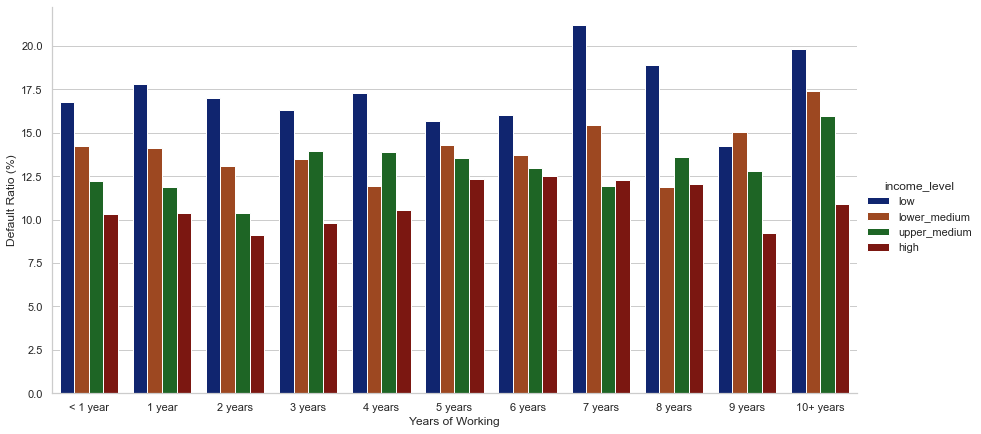

In [34]:
g = sns.catplot(
    data=flattened_table,
    kind='bar',
    x='emp_length',
    y='default_ratio',
    hue='income_level',
    palette='dark',
    orient='v',
    hue_order=[
        'low',
        'lower_medium',
        'upper_medium',
        'high',
    ],
    order=[
        '< 1 year',
        '1 year',
        '2 years',
        '3 years',
        '4 years',
        '5 years',
        '6 years',
        '7 years',
        '8 years',
        '9 years',
        '10+ years',
    ],
    height=6, 
    aspect=12/6,
)
g.set_axis_labels('Years of Working','Default Ratio (%)')

Year of working seems unable to tell if the borrower would go default or not. But it was very clear that income level has a negative relationship with default ratio, <b> higher income implies less default risk and vice versa.</b>

## Analysis on Income Verification Status & Default Risk

In [37]:
# Calculate Default Ratio by Verification
defaulters_ratio_by_verification = loan.groupby(['verification_status','income_level','loan_status'])['loan_status'].count().unstack(level=2)
defaulters_ratio_by_verification.fillna(0,inplace=True)
borrowers_by_verification = defaulters_ratio_by_verification.sum(axis=1)
defaulters_ratio_by_verification['default_ratio'] = defaulters_ratio_by_verification['Charged Off'] / borrowers_by_verification * 100
defaulters_ratio_by_verification = defaulters_ratio_by_verification['default_ratio']
flattened_table = defaulters_ratio_by_verification.reset_index() # create a flattened table for graphing
defaulters_ratio_by_verification = defaulters_ratio_by_verification.unstack(level=1)
defaulters_ratio_by_verification = defaulters_ratio_by_verification.loc[[
    'Not Verified',
    'Verified',
    'Source Verified',
]]
defaulters_ratio_by_verification =  defaulters_ratio_by_verification[[
    'low',
    'lower_medium',
    'upper_medium',
    'high',
]]

print(defaulters_ratio_by_verification)

income_level               low  lower_medium  upper_medium       high
verification_status                                                  
Not Verified         15.962805     12.413644     11.501211   8.942276
Verified             21.788538     18.676749     15.609895  12.264763
Source Verified      17.973022     14.257964     14.370496  10.168758


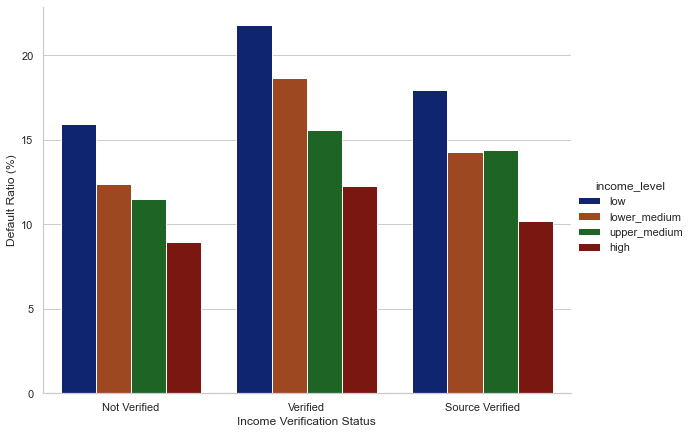

In [38]:
g = sns.catplot(
    data=flattened_table,
    kind='bar',
    x='verification_status',
    y='default_ratio',
    hue='income_level',
    palette='dark',
    orient='v',
    hue_order=[
        'low',
        'lower_medium',
        'upper_medium',
        'high',
    ],
    order=[
        'Not Verified',
        'Verified',
        'Source Verified',
    ],
    height=6, 
    aspect=8/6,
)
g.set_axis_labels('Income Verification Status','Default Ratio (%)')

The default risk consistently decrease from higher income levels to lower income levels are align with previous analysis. However, there seems no relationship between income verification status and default ratio. This result suggests that <b> income verification step seems unneccessary </b> in the loan application process.

## Analysis on Loan Purpose & Default Risk

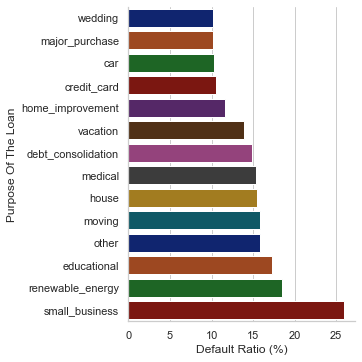

In [41]:
# Calculate Default Ratio by Purpose
defaulters_ratio_by_purpose = loan.groupby(['purpose','loan_status'])['loan_status'].count().unstack(level=1)
defaulters_ratio_by_purpose.fillna(0,inplace=True)
borrowers_by_purpose = defaulters_ratio_by_purpose.sum(axis=1)
defaulters_ratio_by_purpose['default_ratio'] = defaulters_ratio_by_purpose['Charged Off'] / borrowers_by_purpose * 100
defaulters_ratio_by_purpose = defaulters_ratio_by_purpose[['default_ratio']]
defaulters_ratio_by_purpose.reset_index(inplace=True)
defaulters_ratio_by_purpose.sort_values('default_ratio',inplace=True)

# Graph
g = sns.catplot(data=defaulters_ratio_by_purpose,kind='bar',y='purpose',x='default_ratio',orient='h',palette='dark')
g.set_axis_labels('Default Ratio (%)','Purpose Of The Loan')

As we can see, loans offered for financing small businesses are extremely risky with more than 25% chance of default. Loans for renewable energy and education also exhibit great possibility of default. <b>Loans for weddings, major purchases, cars and credit card repayments are safest. </b>

## Analysis on Geography and Default Rate

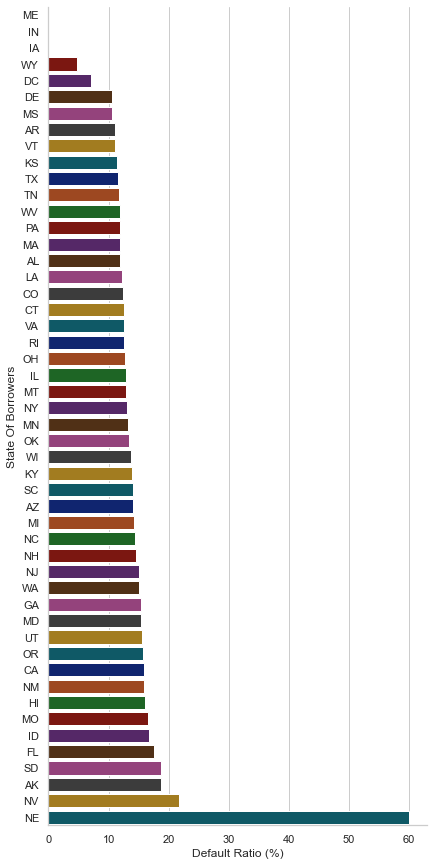

In [44]:
# Calculate Default Ratio by state
defaulters_ratio_by_state = loan.groupby(['addr_state','loan_status'])['loan_status'].count().unstack(level=1)
defaulters_ratio_by_state.fillna(0,inplace=True)
borrowers_by_state = defaulters_ratio_by_state.sum(axis=1)
defaulters_ratio_by_state['default_ratio'] = defaulters_ratio_by_state['Charged Off'] / borrowers_by_state * 100
defaulters_ratio_by_state = defaulters_ratio_by_state[['default_ratio']]
defaulters_ratio_by_state.reset_index(inplace=True)
defaulters_ratio_by_state.sort_values('default_ratio',inplace=True)

# Graph
g = sns.catplot(
    data=defaulters_ratio_by_state,
    kind='bar',
    y='addr_state',
    x='default_ratio',
    orient='h',
    palette='dark',
    height=12, 
    aspect=6/12,
)
g.set_axis_labels('Default Ratio (%)','State Of Borrowers')